# ML Assignment 1

## Logistic Regression

### Logistic Regression on US Census Data Inference

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import sklearn
import random
import matplotlib.colors as mcolors
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

dataset_location = 'uscensus/train.csv'
testdataset_location = 'uscensus/test.csv'
columns =['age','workclass','fnlwgt','education','education-num','marital_status','occupation','relationship','race','sex','capital_gain','capital_loss','hrs_per_week','native_country','pincome']
train = pd.read_csv(dataset_location,names=columns)
train = train.replace(to_replace ="<=50K.",value =0)
train = train.replace(to_replace =">50K.",value =1)
test = pd.read_csv(testdataset_location,names=columns)
test = test.replace(to_replace ="<=50K.",value =0)
test = test.replace(to_replace =">50K.",value =1)
data = pd.concat([train,test])
data.head()

,age,workclass,fnlwgt,education,education-num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hrs_per_week,native_country,pincome
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [2]:
label_encoder = LabelEncoder()
for i in columns:
    if not np.issubdtype(data[i].dtype, np.number):
        data[i]= label_encoder.fit_transform(data[i])
    else:
        data[i] = (data[i]-data[i].min())/(data[i].max()-data[i].min())
    
# data = (data-data.min())/(data.max()-data.min())
data.describe()
def test_train_split(data,split=0.75):
    data_copy = data.copy()
    train = data_copy.sample(frac=split, random_state=0)
    test = data_copy.drop(train.index)
    train = train.sample(frac=1).reset_index(drop=True)
    test = test.sample(frac=1).reset_index(drop=True)
    return train, test

# data.drop('education-num',1)

test, train = test_train_split(data,split=len(train)/(len(train)+len(test)))
test_y,test_x = test['pincome'],data.drop('pincome',1)

In [3]:
def cross_validation_split(data, folds=5):
    splits = np.array_split(data, folds)
    y_splits = np.array_split(data['pincome'], folds)
    x_splits = np.array_split(data.drop('pincome',1), folds)
    return x_splits,y_splits

[x_splits,y_splits] = cross_validation_split(train)

In [17]:
class LogisticRegression(object):    
    def __init__(self, x_in, y_in, folds,learningrate=0.05, iterations=100, regularization = None, penalty = 0.01):
        self.x_splits = x_in
        self.y_splits = y_in
        self.learningrate = learningrate
        self.iterations = iterations
        self.regularization = regularization
        self.penalty = penalty
        self.folds = folds
        
    def avi(self, x_in, y_in, folds,learningrate=0.05, iterations=100, regularization = None, penalty = 0.01,graph=True):
        train_score,validation_score,weights = self.train(x_in, y_in, folds,learningrate, iterations, regularization, penalty)
        if graph:
            fig2, ax2 = plt.subplots()  
            ax2.set_title("Accuracy and Error vs Iterations on Validation Set, Regularization "+ str(regularization)) 
            ax2.plot(np.arange(len(validation_score)), validation_score, 'b',label='accuracy')
            ax2.plot(np.arange(len(validation_score)), np.ones(len(validation_score))-validation_score , 'r',label='error')  
            ax2.set_xlabel('Iterations')  
            ax2.set_ylabel('Accuracy')
            ax2.legend()
            fig, ax = plt.subplots()
            ax.set_title("Accuracy and Error vs Iterations on Train Set, Regularization "+ str(regularization))
            ax.plot(np.arange(len(train_score)), train_score, 'b',label='accuracy')
            ax.plot(np.arange(len(train_score)), np.ones(len(train_score))-train_score, 'r',label='error')
            ax.set_xlabel('Iterations')  
            ax.set_ylabel('Error')
        return train_score[len(train_score)-1],validation_score[len(train_score)-1],weights
        
    def train(self, x_in, y_in, folds,learningrate=0.05, iterations=100, regularization = None, penalty = 0.01):
        tol = 10**-6
        self.x_splits = x_in
        self.y_splits = y_in
        self.learningrate = learningrate
        self.iterations = iterations
        self.folds = folds
        tolerance = tol * np.ones([1,self.x_splits[0].shape[1]+1])
        self.weights = np.zeros(self.x_splits[0].shape[1]+1)
        self.costs = []
        train_score = []
        validation_score = []

        train_score = []
        validation_score = []
        for i in range(iterations):
            train_folds_score = np.zeros(self.folds)
            validation_folds_score = np.zeros(self.folds)
            for fold in range(0, self.folds):
                x_csplits, y_csplits = x_splits.copy(), y_splits.copy()
                X_val,Y_val = x_csplits.pop(fold),y_csplits.pop(fold)
                X_train,Y_train = pd.concat(x_csplits), pd.concat(y_csplits)
                # Y_val, Y_train= Y_val.values.reshape([Y_val.shape[0],1]), Y_train.values.reshape([Y_train.shape[0],1])
                ones = np.ones([X_train.shape[0],1])
                X_train = np.concatenate((ones,X_train),axis=1)
                ones = np.ones([X_val.shape[0],1])
                X_val = np.concatenate((ones,X_val),axis=1)
                # print(X_train.shape,Y_train.shape,X_val.shape,Y_val.shape)
                z = np.dot(X_train, self.weights)
                errors = Y_train - self.logistic_func(z)
                if self.regularization=='L2' and self.penalty!=0:                
                    delta_w = self.learningrate * (np.dot(errors, X_train) + self.penalty*np.sum(np.absolute(self.weights)))
                elif self.regularization=='L1' and self.penalty!=0:
                    delta_w = self.learningrate * (np.dot(errors, X_train) + self.penalty*np.sum(np.power(self.weights,2)))
                else:
                    delta_w = self.learningrate * np.dot(errors, X_train)
                self.weights += delta_w                                
                if self.regularization=='L2' and self.penalty!=0:
                    self.costs.append(l2_logiklihood(X_train, self.weights, Y_train, self.penalty))
                else:
                    self.costs.append(logliklihood(z, Y_train))
                train_folds_score[fold]=(self.evaluate(X_train, Y_train))
                validation_folds_score[fold]=(self.evaluate(X_val,Y_val))
            # print(train_folds_score,validation_folds_score)
            train_score.append(train_folds_score.mean())
            validation_score.append(validation_folds_score.mean())
            if not np.all(abs(delta_w) >= tolerance): 
                break
        return train_score,validation_score,self.costs
                    
    def predict(self, X_test, conf = 0.5):
        try:
            z = np.dot(X_test, self.weights)
        except ValueError:
            ones = np.ones([X_test.shape[0],1])
            X_test = np.concatenate((ones,X_test),axis=1)
            z = np.dot(X_test, self.weights)
        probs = np.array([logistic_func(i) for i in z])
        predictions = np.where(probs >= conf, 1, 0)
        return predictions, probs
        
    def evaluate(self, x_test, y_test):
        predictions, probs  = self.predict(x_test)
        TP, TN, FP, FN, P, N = 0, 0, 0, 0, 0, 0
        for idx, test_sample in enumerate(y_test):
            if predictions[idx] == 1 and test_sample == 1:
                TP += 1       
                P += 1
            elif predictions[idx] == 0 and test_sample == 0:                
                TN += 1
                N += 1
            elif predictions[idx] == 0 and test_sample == 1:
                FN += 1
                P += 1
            elif predictions[idx] == 1 and test_sample == 0:
                FP += 1
                N += 1
            
        accuracy = (TP+TN)/(P+N)
        error = (FP+FN)/(P+N)       
        return accuracy
    def logistic_func(self,z):   
        return 1 / (1 + np.exp(-z))    
    
def logistic_func(z):   
    return 1 / (1 + np.exp(-z))  
    
def logliklihood(z, y):
    return -1 * np.sum((y * np.log(logistic_func(z))) + ((1 - y) * np.log(1 - logistic_func(z))))
    
def l2_logiklihood(x, weights, y, penalty):
    z = np.dot(x, weights) 
    reg_term = (1 / (2 * penalty)) * np.dot(weights.T, weights)
    
    return -1 * np.sum((y * np.log(logistic_func(z))) + ((1 - y) * np.log(1 - logistic_func(z)))) + reg_term


#### Logistic Regression without regularization

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in log


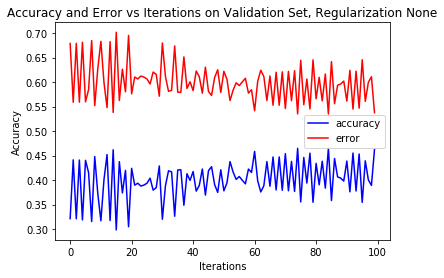

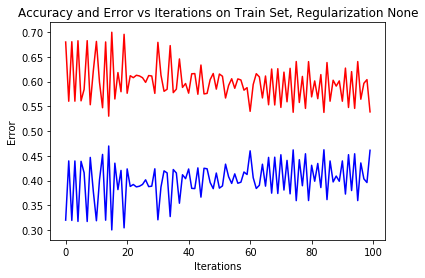

In [18]:
model = LogisticRegression(x_splits, y_splits, folds=5,learningrate=0.05, iterations=100, regularization = None, penalty = 0.01)
train_score, val_score, _ = model.avi(x_splits, y_splits, folds=5,learningrate=0.05, iterations=100, regularization = None, penalty = 1)
test_score = model.evaluate(test_x,test_y)

In [19]:
print("Train score",train_score,"Validation Score",val_score,"Test Score",test_score)

Train score 0.4611525793342149 Validation Score 0.46251490549168617 Test Score 0.5687968267959453


#### Logistic Regression with L2 regularization

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:123: RuntimeWarning: divide by zero encountered in log


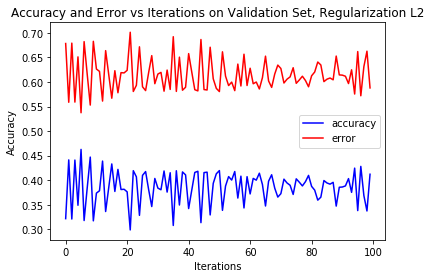

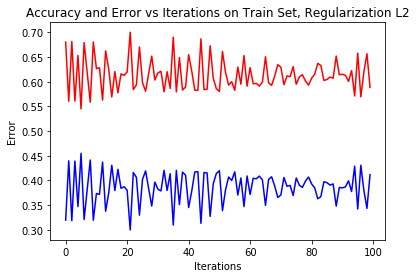

In [21]:
model = LogisticRegression(x_splits, y_splits, folds=5,learningrate=0.05, iterations=100, regularization = 'L2', penalty = 0.01)
train_score, test_Score, _ = model.avi(x_splits, y_splits, folds=5,learningrate=0.05, iterations=100, regularization = 'L2', penalty = 1)
test_score = model.evaluate(test_x,test_y)

In [22]:
print("Train score",train_score,"Validation Score",val_score,"Test Score",test_score)

Train score 0.4116170857276523 Validation Score 0.46251490549168617 Test Score 0.4968267959453504


#### Logistic Regression with L1 regularization

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in log
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: overflow encountered in power
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in greater_equal
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in greater_equal


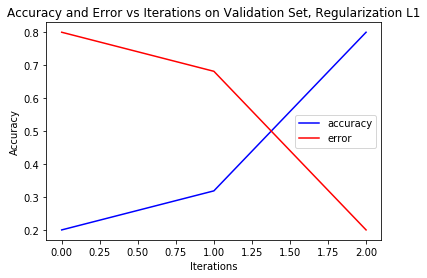

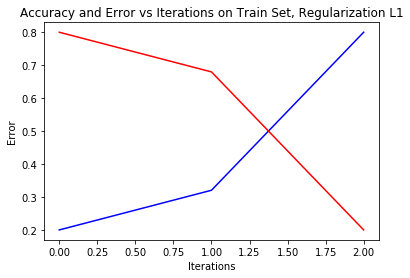

In [24]:
model = LogisticRegression(x_splits, y_splits, folds=5,learningrate=0.05, iterations=100, regularization = 'L1', penalty = 0.01)
train_score, test_Score, _ = model.avi(x_splits, y_splits, folds=5,learningrate=0.05, iterations=100, regularization = 'L1', penalty = 1)
test_score = model.evaluate(test_x,test_y)

In [25]:
print("Train score",train_score,"Validation Score",val_score,"Test Score",test_score)

Train score 0.8000301599848536 Validation Score 0.46251490549168617 Test Score 0.6658880564125166


## L1 Regularisation works better than L2 Regularisation

### MNIST Logistic Regression

In [11]:
def loadMNIST( prefix, folder ):
    intType = np.dtype( 'int32' ).newbyteorder( '>' )
    nMetaDataBytes = 4 * intType.itemsize

    data = np.fromfile( folder + "/" + prefix + '-images.idx3-ubyte', dtype = 'ubyte' )
    magicBytes, nImages, width, height = np.frombuffer( data[:nMetaDataBytes].tobytes(), intType )
    data = data[nMetaDataBytes:].astype( dtype = 'float32' ).reshape( [ nImages, width * height ] )
    labels = np.fromfile( folder + "/" + prefix + '-labels.idx1-ubyte',dtype = 'ubyte' )[2 * intType.itemsize:]

    return data, labels
train_images, train_labels = loadMNIST( "train", "mnist" )
test_images, test_labels = loadMNIST( "t10k", "mnist" )
print(train_images.shape,train_labels.shape)

(60000, 784) (60000,)


In [12]:
from sklearn.linear_model import LogisticRegression
ovr = LogisticRegression(solver = 'lbfgs', multi_class='ovr',verbose=1,max_iter=10000)
l2 = LogisticRegression(penalty='l2',solver = 'lbfgs',verbose=1,max_iter=10000)
l1 = LogisticRegression(penalty='l1',solver = 'liblinear',verbose=1,max_iter=10000)
scaler = StandardScaler()
X = scaler.fit_transform(train_images)
l2_models = [LogisticRegression(penalty='l2',solver = 'lbfgs',verbose=10,max_iter=100) for i in range(10)]
l1_models = [LogisticRegression(penalty='l1',solver = 'liblinear',verbose=10,max_iter=100) for i in range(10)]
l2_scores, l1_scores = [0 for i in range(10)], [0 for i in range(10)]
for i in range(10):
    print("Training ",i)
    Y = train_labels
    Y = np.where(Y==i,1,0)
    l2_models[i] = l2_models[i].fit(X,Y)
    l1_models[i] = l1_models[i].fit(X,Y)

Training  0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.2s finished


[LibLinear]Training  1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.4s finished


[LibLinear]Training  2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.1s finished


[LibLinear]Training  3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.8s finished


[LibLinear]Training  4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.8s finished


[LibLinear]Training  5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.6s finished


[LibLinear]Training  6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.8s finished


[LibLinear]Training  7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.5s finished


[LibLinear]

C:\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training  8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.3s finished


[LibLinear]Training  9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.5s finished


[LibLinear]

In [13]:
l2_tscores, l1_tscores = [0 for i in range(10)], [0 for i in range(10)]
l2_vscores, l1_vscores = [0 for i in range(10)], [0 for i in range(10)]
for i in range(10):
    test_Y, train_Y = test_labels, train_labels
    test_Y, train_Y = np.where(test_Y==i,1,0), np.where(train_Y==i,1,0)
    l2_tscores[i] = l2_models[i].score(train_images,train_Y)
    l1_vscores[i] = l1_models[i].score(test_images,test_Y)
    l2_tscores[i] = l2_models[i].score(train_images,train_Y)
    l1_vscores[i] = l1_models[i].score(test_images,test_Y)
print("L2 Train scores",l2_tscores)
print("L2 Test scores",l2_vscores)
print("L1 Train scores",l1_tscores)
print("L1 Test scores",l1_vscores)

L2 Train scores [0.94195, 0.9882, 0.9203666666666667, 0.8158833333333333, 0.9401833333333334, 0.9649333333333333, 0.9233833333333333, 0.9834166666666667, 0.31216666666666665, 0.7662666666666667]
L2 Test scores [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
L1 Train scores [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
L1 Test scores [0.9445, 0.9886, 0.9294, 0.8113, 0.9337, 0.9676, 0.9251, 0.9692, 0.3063, 0.7649]


## model is underfitting

In [14]:
from sklearn.metrics import roc_curve

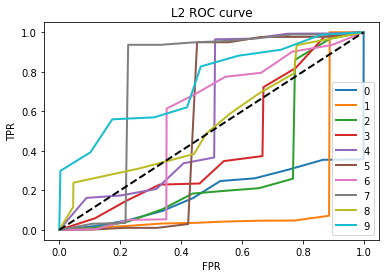

In [15]:
for i in range(10):
    fpr, tpr,_=roc_curve(l2_models[i].predict(test_images),test_labels,drop_intermediate=False)
    plt.plot(fpr, tpr, color=list(mcolors.TABLEAU_COLORS)[i],lw=2, label=i)    
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('L2 ROC curve')
plt.show()